In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from scipy.optimize import least_squares

## Оптимизация весов с использованием L2-регуляризации

Для получения оптимальных весов используется **МНК** с добавлением $L2$ - регуляризации. Этот метод минимизирует сумму квадратов невязок $ residuals $, которые определяются как разница между текущими предсказаниями модели и целевыми значениями $ WMAE $.

### Шаги метода

#### 1. **Определение функции невязок**
Функция `residuals_func_reg` вычисляет:
- Основные невязки $residuals\_main$ для каждого класса k в зависимости от текущих весов  $w$:
  $$
  \text{residual}_k = \frac{\sum_{j=0}^6 w_j \cdot |j - k|}{\sum_{j=0}^6 w_j} - WMAE[k].
  $$
- Штраф за регуляризацию $ penalty $:
  $$
  \text{penalty} = \sqrt{\lambda} \cdot w.
  $$
Функция возвращает объединённый массив невязок и штрафов.

#### 2. **Оптимизация для одного запуска**
Используется метод **`least_squares`** из библиотеки `scipy.optimize`, который минимизирует сумму квадратов невязок:
$$
\min_{w} ||residuals\_main||^2 + \lambda \cdot \|w\|^2.
$$
- Ограничения: веса  $w$ должны быть в диапазоне $[10^{-4}, 25]$.
- Начальные значения весов $ x_0 $ задаются случайно.

#### 3. **Многократный запуск (Multistart Optimization)**
Функция `multistart_optimization_reg` выполняет оптимизацию несколько раз $ n\_starts $, начиная с разных случайных начальных точек $ x_0 $. Для каждого запуска:
- Вычисляется целевая функция (сумма квадратов невязок).  
- Сохраняется решение с минимальной ошибкой.  

Это помогает избежать застревания в локальных минимумах.

---

### Итоговый метод
- **Метод наименьших квадратов (Least Squares):** оптимизация невязок.  
- **L2 -регуляризация:** сглаживает веса, предотвращая их раздувание.  
- **Многократные запуски:** минимизация зависимости от начальных условий.  

In [2]:
# WMAE: Взвешенная средняя абсолютная ошибка для каждого класса (k=0..6), которая получена из Public части серевнования.
# Эти значения представляют целевую метрику, которую нужно аппроксимировать для каждого индекса класса.


WMAE = np.array([
    1.10928, 0.81635, 0.98410, 1.37129,
    1.91849, 2.58163, 3.29162
])

In [3]:
def residuals_func_reg(w, lambda_):
    """
    Вычисляет невязки (residuals) и штраф за L2-регуляризацию для оптимизации.
    """
    eps = 1e-9
    W = np.sum(w)
    denom = W if W > 0 else eps
    
    # Основные residuals
    residuals_main = []
    for k in range(7):
        num = sum(w[j] * abs(j - k) for j in range(7))
        avg_dist = num / denom
        residual_k = avg_dist - WMAE[k]
        residuals_main.append(residual_k)
    
    # L2-штраф
    penalty = np.sqrt(lambda_) * w
    
    return np.concatenate([residuals_main, penalty])

def run_single_optimization_reg(x0, lambda_):
    """
    Запускает оптимизацию из заданной начальной точки x0,
    используя residuals_func_reg с коэффициентом L2-регуляризации lambda_.
    """
    return least_squares(
        fun=lambda w: residuals_func_reg(w, lambda_),
        x0=x0,
        bounds=(1e-4, 25),  # нижняя граница 1e-4, верхняя 25
        xtol=1e-12,
        ftol=1e-12,
        gtol=1e-12
    )

def multistart_optimization_reg(n_starts=10, lambda_=0.01):
    """
    Многократный запуск (multistart) оптимизации (L2-регуляризация)
    Возвращает best_res - структуру результата от least_squares.
    """
    best_res = None
    best_cost = float("inf")

    for i in range(n_starts):
        x0 = np.random.uniform(0.1, 10, size=7)

        res = run_single_optimization_reg(x0, lambda_)
        
        cost = np.sum(res.fun**2)

        if cost < best_cost:
            best_cost = cost
            best_res = res
    
    return best_res

In [4]:
n_starts = 100
lambda_ = 1e-9

best_solution = multistart_optimization_reg(
    n_starts=n_starts,
    lambda_=lambda_,
)

w_sol = best_solution.x
residual_vals = residuals_func_reg(w_sol, lambda_)[:7]


print("optimized_weights:", w_sol)
print("residual_norm:", np.sqrt(np.sum(residual_vals**2)))

optimized_weights: [1.00000000e-04 2.50000000e+01 1.12262326e+01 5.60813870e+00
 1.03950570e+01 1.00000000e-04 1.00000000e-04]
residual_norm: 1.2276031785828598


## Анализ результатов


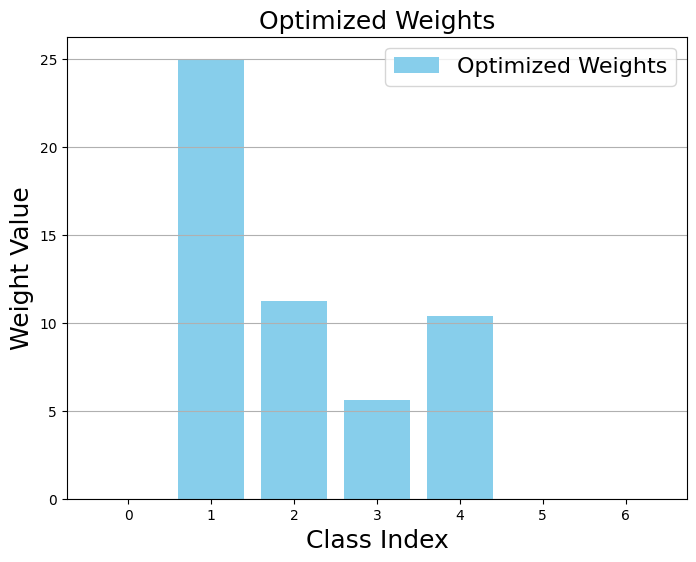

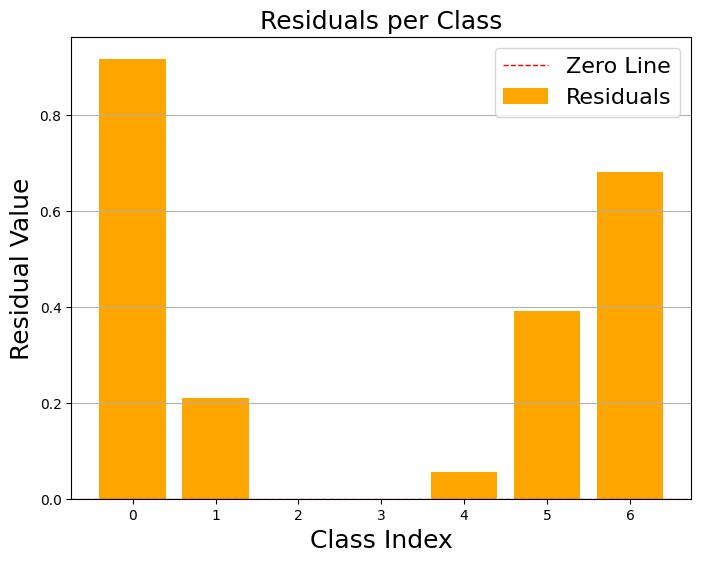

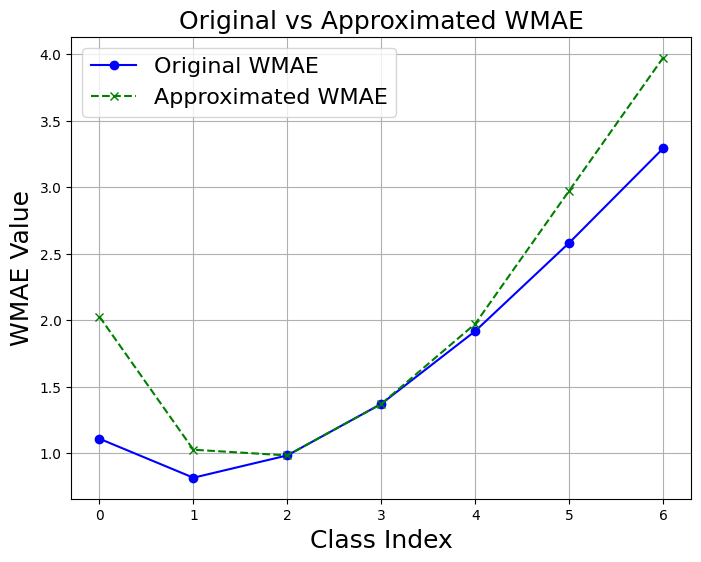

In [5]:
# 1. Визуализация оптимизированных весов
plt.figure(figsize=(8, 6))
plt.bar(range(len(w_sol)), w_sol, color='skyblue', label='Optimized Weights')
plt.xlabel('Class Index', fontsize=18)
plt.ylabel('Weight Value', fontsize=18)
plt.title('Optimized Weights', fontsize=18)
plt.xticks(range(len(w_sol)), labels=range(len(w_sol)))
plt.legend(fontsize=16)
plt.grid(axis='y')
plt.show()

# 2. Визуализация residuals
plt.figure(figsize=(8, 6))
plt.bar(range(len(residual_vals)), residual_vals, color='orange', label='Residuals')
plt.xlabel('Class Index', fontsize=18)
plt.ylabel('Residual Value', fontsize=18)
plt.title('Residuals per Class', fontsize=18)
plt.xticks(range(len(residual_vals)), labels=range(len(residual_vals)))
plt.axhline(0, color='red', linestyle='--', linewidth=1, label='Zero Line')
plt.legend(fontsize=16)
plt.grid(axis='y')
plt.show()

# 3. Проверка приближения WMAE
predicted_wmae = []
for k in range(len(WMAE)):
    num = sum(w_sol[j] * abs(j - k) for j in range(len(WMAE)))
    denom = np.sum(w_sol)
    predicted_wmae.append(num / denom)

# Визуализация сравнения оригинального и приближенного WMAE
plt.figure(figsize=(8, 6))
plt.plot(range(len(WMAE)), WMAE, 'o-', label='Original WMAE', color='blue')
plt.plot(range(len(WMAE)), predicted_wmae, 'x--', label='Approximated WMAE', color='green')
plt.xlabel('Class Index', fontsize=18)
plt.ylabel('WMAE Value', fontsize=18)
plt.title('Original vs Approximated WMAE', fontsize=18)
plt.legend(fontsize=16)
plt.grid()
plt.show()